In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


In [3]:
df_imdb=pd.read_csv("IMDb Movies India.csv",encoding='latin-1')
#Getting a brief intro to the dataset
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [4]:
#Visually identifying missing values and the dataset's arrangement
df_imdb.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [5]:
print(df_imdb['Name'].isna().sum())
print(df_imdb['Rating'].isna().sum())

0
7590


In [6]:
df_imdb['Name'] = df_imdb['Name'].replace('', np.nan)
print(df_imdb['Name'].isna().sum())

0


In [7]:

df = df_imdb.copy()
df = df[df['Name'].notna()]

# Clean Year (remove parentheses and convert to numeric)
df['Year'] = df['Year'].str.extract(r'(\d{4})').astype(float)

# Convert Duration to numeric (remove ' min')
df['Duration'] = df['Duration'].str.replace(' min', '', regex=False).astype(float)

# Clean Votes (remove commas and convert to numeric)
df['Votes'] = df['Votes'].str.replace(',', '', regex=False)
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

df.reset_index(drop=True, inplace=True)

# Display cleaned dataset info
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Duration  7240 non-null   float64
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7919 non-null   float64
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.2+ MB


(None,
                                  Name    Year  Duration            Genre  \
 0                                         NaN       NaN            Drama   
 1  #Gadhvi (He thought he was Gandhi)  2019.0     109.0            Drama   
 2                         #Homecoming  2021.0      90.0   Drama, Musical   
 3                             #Yaaram  2019.0     110.0  Comedy, Romance   
 4                   ...And Once Again  2010.0     105.0            Drama   
 
    Rating  Votes            Director       Actor 1             Actor 2  \
 0     NaN    NaN       J.S. Randhawa      Manmauji              Birbal   
 1     7.0    8.0       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
 2     NaN    NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
 3     4.4   35.0          Ovais Khan       Prateik          Ishita Raj   
 4     NaN    NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   
 
            Actor 3  
 0  Rajendra Bhatia  
 1    Arvind Jangid  
 2       Ro

In [8]:
df_train = df[df['Rating'].notna()]
df_topredict = df[df['Rating'].isna()]
df_train.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,1997.0,147.0,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,2005.0,142.0,"Drama, Romance, War",7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,2012.0,82.0,"Horror, Mystery, Thriller",5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [9]:
duration_median = df_train['Duration'].median()
df_train['Duration']=df_train['Duration'].fillna(duration_median)
df_topredict['Duration']=df_topredict['Duration'].fillna(duration_median)

C:\Users\anura\AppData\Local\Temp\ipykernel_12772\4084282635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Duration']=df_train['Duration'].fillna(duration_median)
C:\Users\anura\AppData\Local\Temp\ipykernel_12772\4084282635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topredict['Duration']=df_topredict['Duration'].fillna(duration_median)


In [10]:
print(df_train.columns)

Index(['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3'],
      dtype='object')


In [11]:
print((df_train.shape))
for col in ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3']:
    unique_count = df_train[col].nunique()
    print(f"Number of unique elements in {col}: {unique_count}")

print((df_topredict.shape))
for col in ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director',
       'Actor 1', 'Actor 2', 'Actor 3']:
    unique_count = df_topredict[col].nunique()
    print(f"Number of unique elements in {col}: {unique_count}")
    
    
    

(7919, 10)
Number of unique elements in Name: 7372
Number of unique elements in Year: 92
Number of unique elements in Duration: 178
Number of unique elements in Genre: 432
Number of unique elements in Rating: 84
Number of unique elements in Votes: 2033
Number of unique elements in Director: 3139
Number of unique elements in Actor 1: 2551
Number of unique elements in Actor 2: 2873
Number of unique elements in Actor 3: 3064
(7590, 10)
Number of unique elements in Name: 7122
Number of unique elements in Year: 101
Number of unique elements in Duration: 144
Number of unique elements in Genre: 242
Number of unique elements in Rating: 0
Number of unique elements in Votes: 0
Number of unique elements in Director: 3766
Number of unique elements in Actor 1: 2956
Number of unique elements in Actor 2: 2893
Number of unique elements in Actor 3: 2603


In [12]:
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    df_train[col]=df_train[col].fillna('Unknown')
    df_topredict[col]=df_topredict[col].fillna('Unknown')

C:\Users\anura\AppData\Local\Temp\ipykernel_12772\4122677427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[col]=df_train[col].fillna('Unknown')
C:\Users\anura\AppData\Local\Temp\ipykernel_12772\4122677427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topredict[col]=df_topredict[col].fillna('Unknown')


In [13]:
df_train['Primary Genre'] = df_train['Genre'].str.split(',').str[0].str.strip()
df_topredict['Primary Genre'] = df_topredict['Genre'].str.split(',').str[0].str.strip()

C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1028309248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Primary Genre'] = df_train['Genre'].str.split(',').str[0].str.strip()
C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1028309248.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topredict['Primary Genre'] = df_topredict['Genre'].str.split(',').str[0].str.strip()


In [14]:
for col in ['Actor 1', 'Actor 2', 'Actor 3','Director','Primary Genre']:
    actor_rating = df_train.groupby(col)['Rating'].mean()
    df_train[f'{col}_Score'] = df_train[col].map(actor_rating)
    df_topredict[f'{col}_Score'] = df_topredict[col].map(actor_rating)
    # Fill unseen actors with overall mean
    df_train[f'{col}_Score'].fillna(df_train['Rating'].mean(), inplace=True)
    df_topredict[f'{col}_Score'].fillna(df_train['Rating'].mean(), inplace=True)


C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1989239545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f'{col}_Score'] = df_train[col].map(actor_rating)
C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1989239545.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topredict[f'{col}_Score'] = df_topredict[col].map(actor_rating)
C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1989239545.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained

In [15]:
df_train.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Primary Genre,Actor 1_Score,Actor 2_Score,Actor 3_Score,Director_Score,Primary Genre_Score
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,Drama,6.850000,7.000000,7.000000,7.000000,6.172393
3,#Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,Comedy,5.420000,4.400000,4.450000,4.400000,5.811429
5,...Aur Pyaar Ho Gaya,1997.0,147.0,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,Comedy,4.788889,5.786667,5.846154,5.358824,5.811429
6,...Yahaan,2005.0,142.0,"Drama, Romance, War",7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,Drama,5.356000,6.050000,6.500000,7.500000,6.172393
8,?: A Question Mark,2012.0,82.0,"Horror, Mystery, Thriller",5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,Horror,5.600000,5.883333,5.600000,5.600000,4.687234


In [16]:
X_train = df_train[['Year', 'Duration', 'Votes','Director_Score','Primary Genre_Score','Actor 1_Score','Actor 2_Score','Actor 3_Score']]
y_train = df_train['Rating']
X_predict = df_topredict[['Year', 'Duration', 'Votes','Director_Score','Primary Genre_Score','Actor 1_Score','Actor 2_Score','Actor 3_Score']]

X_train.head(), y_train.head()

#,'Director_Score','Primary Genre_Score','Actor 1_Score','Actor 2_Score','Actor 3_Score'

(     Year  Duration   Votes  Director_Score  Primary Genre_Score  \
 1  2019.0     109.0     8.0        7.000000             6.172393   
 3  2019.0     110.0    35.0        4.400000             5.811429   
 5  1997.0     147.0   827.0        5.358824             5.811429   
 6  2005.0     142.0  1086.0        7.500000             6.172393   
 8  2012.0      82.0   326.0        5.600000             4.687234   
 
    Actor 1_Score  Actor 2_Score  Actor 3_Score  
 1       6.850000       7.000000       7.000000  
 3       5.420000       4.400000       4.450000  
 5       4.788889       5.786667       5.846154  
 6       5.356000       6.050000       6.500000  
 8       5.600000       5.883333       5.600000  ,
 1    7.0
 3    4.4
 5    4.7
 6    7.4
 8    5.6
 Name: Rating, dtype: float64)

In [17]:

# Split data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest" :RandomForestRegressor(n_estimators=700, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=700, learning_rate=0.7, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=600, learning_rate=0.4, max_depth=6, random_state=42),
    "Cat Boost Regressor":CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(256,128,64),max_iter=1000,early_stopping=True,random_state=42,verbose=10)
}   

# Train and evaluate
for name, model in models.items():
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    print(f"{name} — MSE: {mse:.4f}, R2: {r2:.4f}")


Random Forest — MSE: 0.3716, R2: 0.8001
Ridge Regression — MSE: 0.4514, R2: 0.7572
Gradient Boosting — MSE: 0.4819, R2: 0.7408
XGBoost — MSE: 0.4534, R2: 0.7561
Cat Boost Regressor — MSE: 0.3441, R2: 0.8149
Iteration 1, loss = 5494.96572126
Validation score: -33989.572572
Iteration 2, loss = 1306.96911290
Validation score: -53865.080451
Iteration 3, loss = 826.19636655
Validation score: -37479.759083
Iteration 4, loss = 10698.14898574
Validation score: -13700.507780
Iteration 5, loss = 354.51465320
Validation score: -377.265545
Iteration 6, loss = 41.20827612
Validation score: -61.115888
Iteration 7, loss = 51.76067283
Validation score: -676.170076
Iteration 8, loss = 199.87477268
Validation score: -5430.068113
Iteration 9, loss = 438.60445976
Validation score: -89.275702
Iteration 10, loss = 80.02747814
Validation score: -132.087842
Iteration 11, loss = 33.22032901
Validation score: -77.428579
Iteration 12, loss = 9.21411175
Validation score: -6.770798
Iteration 13, loss = 3.87261019


In [18]:
DL_model = Sequential([
    Dense(1024, activation='relu', input_shape=(X_tr.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(1)
])

DL_model.compile(optimizer='adam', loss='mae', metrics=['mse'])
DL_model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=75, batch_size=32, verbose=1)

DL_preds=DL_model.predict(X_val)
mse = mean_squared_error(y_val, DL_preds)
r2 = r2_score(y_val, DL_preds)
print(f"Deep Learning — MSE: {mse:.4f}, R2: {r2:.4f}")

C:\Users\anura\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.7432 - mse: 5.6914 - val_loss: 1.2554 - val_mse: 2.6994
Epoch 2/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2177 - mse: 2.4755 - val_loss: 2.3132 - val_mse: 7.2076
Epoch 3/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0728 - mse: 1.9720 - val_loss: 2.0849 - val_mse: 5.7199
Epoch 4/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.9603 - mse: 1.5417 - val_loss: 0.9586 - val_mse: 1.4860
Epoch 5/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9435 - mse: 1.4804 - val_loss: 1.2399 - val_mse: 2.2969
Epoch 6/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8960 - mse: 1.3443 - val_loss: 0.8888 - val_mse: 1.3435
Epoch 7/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8753 - mse: 1.3011 - val_loss: 1.1472 - val_mse: 2.1828
Epoch 8/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8636 - mse: 1.2501 - val_loss: 1.5797 - val_mse: 3.6518
Epoch 9/75
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - lo

C:\Users\anura\AppData\Local\Temp\ipykernel_12772\1789312270.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_feat_imp.head(15), y=cat_feat_imp.head(15).index, palette='viridis')


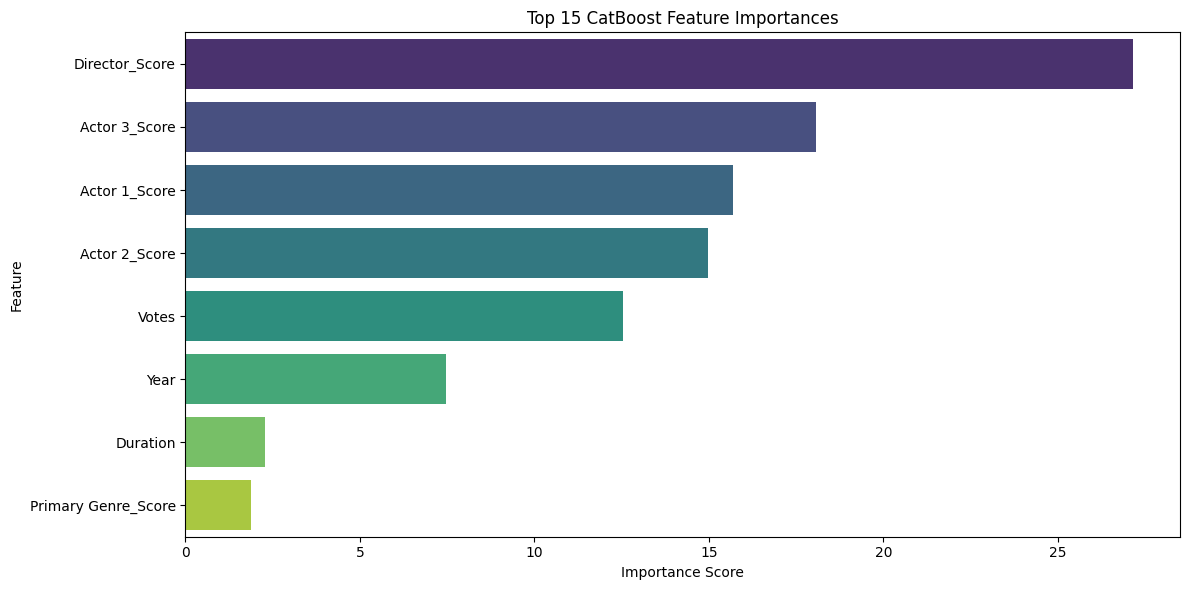

In [19]:
#Retraining the CatBoost and Random Forest seperately to get the feature importance plot,
#Then further moving on with an ensemble model of both
rf_model=RandomForestRegressor(n_estimators=700, random_state=42)
cat_model= CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6)

rf_model.fit(X_tr,y_tr)
cat_model.fit(X_tr,y_tr)

cat_feat_imp = pd.Series(cat_model.get_feature_importance(), index=X_train.columns).sort_values(ascending=False)
rf_feat_imp = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)


# Plot CatBoost Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=cat_feat_imp.head(15), y=cat_feat_imp.head(15).index, palette='viridis')
plt.title("Top 15 CatBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

C:\Users\anura\AppData\Local\Temp\ipykernel_12772\3123030890.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rf_feat_imp.head(15), y=rf_feat_imp.head(15).index, palette='magma')


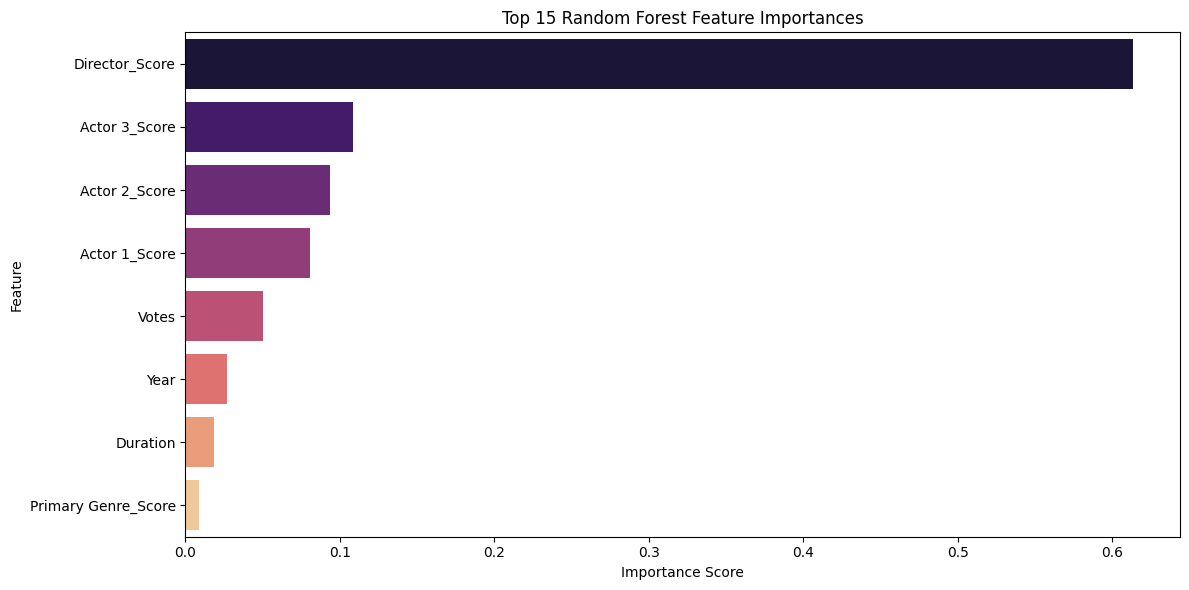

In [20]:
# Plot Random Forest Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_feat_imp.head(15), y=rf_feat_imp.head(15).index, palette='magma')
plt.title("Top 15 Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:

ensemble = VotingRegressor([
    ('rf',RandomForestRegressor(n_estimators=700, random_state=42) ),
    ('cat', CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6))
])
ensemble.fit(X_tr, y_tr)
ensemble_preds = ensemble.predict(X_val)


mse = mean_squared_error(y_val, ensemble_preds)
r2 = r2_score(y_val, ensemble_preds)
print(f"Ensemble — MSE: {mse:.4f}, R²: {r2:.4f}")


Ensemble — MSE: 0.3459, R²: 0.8139


In [22]:
predicted_ratings = ensemble.predict(X_predict)  
df_topredict['Rating'] = predicted_ratings


C:\Users\anura\AppData\Local\Temp\ipykernel_12772\3529006617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topredict['Rating'] = predicted_ratings


In [ ]:
df_topredict

In [ ]:
df_full = pd.concat([df_train, df_topredict], ignore_index=True)


In [25]:
X=df_full[['Year', 'Duration', 'Votes','Director_Score','Primary Genre_Score','Actor 1_Score','Actor 2_Score','Actor 3_Score']]
y=df_full['Rating']

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.3)

In [28]:

ensemble = VotingRegressor([
    ('rf',RandomForestRegressor(n_estimators=700, random_state=42) ),
    ('cat', CatBoostRegressor(verbose=0, iterations=500, learning_rate=0.1, depth=6))
])
ensemble.fit(X_train, y_train)
ensemble_preds = ensemble.predict(X_test)


mse = mean_squared_error(y_test, ensemble_preds)
r2 = r2_score(y_test, ensemble_preds)
print(f"Ensemble — MSE: {mse:.4f}, R²: {r2:.4f}")


Ensemble — MSE: 0.1790, R²: 0.8595
